# DDPM-DRL

In [1]:
from drl.util import make_model, make_reward_distributions, make_classical_conditioning_stimuli
import torch
from purias_utils.util.arguments_yaml import ConfigNamepace

In [16]:
args_path = '/homes/pr450/repos/research_projects/sampling_ddpm/results_link_drl/test/run_5/args.yaml'
state_path = '/homes/pr450/repos/research_projects/sampling_ddpm/results_link_drl/test/run_5/state.mdl'
args = ConfigNamepace.from_yaml_path(args_path)

starting_sigma2 = args.starting_sigma2
ultimate_sigma2 = args.ultimate_sigma2
num_diffusion_timesteps = args.num_diffusion_timesteps
task_time_embedding_size = args.task_time_embedding_size
time_between_cs_and_us = args.time_between_cs_and_us
wait_time = args.wait_time
time_after_us = args.time_after_us
batch_size = args.batch_size
gamma = args.gamma
diffusion_time_embedding_size = 16
device = 'cuda'

sigma2x_schedule = torch.linspace(starting_sigma2, ultimate_sigma2, num_diffusion_timesteps)
std_schedule = torch.sqrt(sigma2x_schedule)

all_reward_distribution_configs = args.all_reward_distributions

(
    all_reward_distributions,
    all_target_rewards_distribution_probs_x_axes,
    all_target_rewards_distribution_probs,
    all_numpy_friendly_reward_distributions,
) = make_reward_distributions(all_reward_distribution_configs)

ddpm_model = make_model(task_time_embedding_size, diffusion_time_embedding_size, sigma2x_schedule, time_between_cs_and_us, len(all_reward_distributions), device)
ddpm_model.load_state_dict(torch.load(state_path))

/tmp/ipykernel_2519173/942240715.py:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ddpm_model.load_state_dict(torch.load(state_path))


<All keys matched successfully>

In [21]:
(
    stimulus_array,
    num_task_timesteps,
    s_t,
    s_t_plus_1,
    s_all,
    input_t,
    input_t_plus_1,
    input_all,
) = make_classical_conditioning_stimuli(
    wait_time,
    time_between_cs_and_us,
    time_after_us,
    batch_size,
    num_diffusion_timesteps,
    device,
)


steps_to_reward = time_between_cs_and_us - stimulus_array - 1
q_value_scaler = (gamma ** steps_to_reward).cpu().numpy()
q_value_scaler[stimulus_array.cpu().numpy() == -1] = 1.0

In [22]:
with torch.no_grad():
    # novel_samples['samples'] of shape [batch, time, 1]
    novel_samples = ddpm_model.generate_samples(
        network_input = input_all,
        samples_shape = [batch_size, num_task_timesteps],
    )

samples = novel_samples['samples'].cpu().numpy()
samples.shape

(2048, 9, 2)

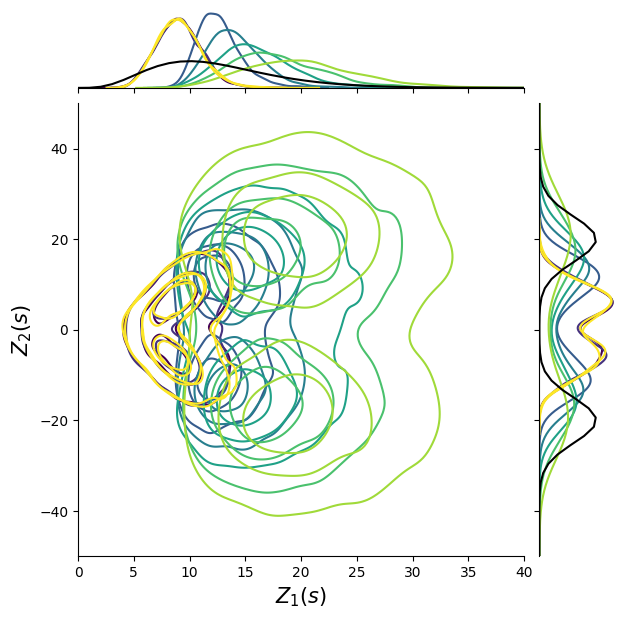

In [87]:
import seaborn as sns
import matplotlib.cm as cmx
from matplotlib import pyplot as plt
import matplotlib.colors as colors

magma = plt.get_cmap("viridis")
cNorm = colors.Normalize(vmin=-wait_time, vmax=time_between_cs_and_us)
task_timesteps_colors_scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=magma)
task_timesteps_colors_scalarMap.set_array([])


# axes[i_r].plot(
#     all_target_rewards_distribution_probs_x_axes[i_r].cpu().numpy(),
#     all_target_rewards_distribution_probs[i_r].cpu().numpy(),
#     label = 'true reward distribution',
#     color = 'black'
# )

g = None

# Plot value distribution
for t in range(-wait_time, time_between_cs_and_us + time_after_us):   # time_since_stim
    adjusted_t = wait_time + t
    
    relevant_preds = novel_samples['samples'][:,adjusted_t].cpu().numpy() # [B, 2]


    t_color = task_timesteps_colors_scalarMap.to_rgba(t)

    if g is None:

        g = sns.jointplot(
            x=relevant_preds[:, 0],
            y=relevant_preds[:, 1],
            kind='kde',  # For 2D histogram
            color=t_color,  # Optional: choose a colormap
            fill=False,  # This ensures only contour lines are shown
            levels = 4
        )

    else:

        sns.kdeplot(
            x=relevant_preds[:, 0],
            y=relevant_preds[:, 1],
            color=t_color,  # Optional: choose a colormap
            fill=False,  # This ensures only contour lines are shown
            ax = g.ax_joint,
            levels = 4
        )

        sns.kdeplot(x=relevant_preds[:, 0], ax=g.ax_marg_x, color=t_color, fill=False)
        sns.kdeplot(y=relevant_preds[:, 1], ax=g.ax_marg_y, color=t_color, fill=False)



g.ax_marg_x.plot(
    all_target_rewards_distribution_probs_x_axes[0].cpu().numpy(),
    all_target_rewards_distribution_probs[0].cpu().numpy(),
    label = 'true reward distribution',
    color = 'black'
)

g.ax_marg_y.plot(
    all_target_rewards_distribution_probs[1].cpu().numpy(),
    all_target_rewards_distribution_probs_x_axes[1].cpu().numpy(),
    label = 'true reward distribution',
    color = 'black'
)


g.ax_joint.set_xlabel('$Z_1(s)$', fontsize = 15)
g.ax_joint.set_ylabel('$Z_2(s)$', fontsize = 15)
g.ax_joint.set_xlim(0, 40)
g.ax_joint.set_ylim(-50, +50)


plt.savefig('z_mate50_symposium_images/drl_returns_hist.svg', format = 'svg', transparent = True)

# Intro to diffusion

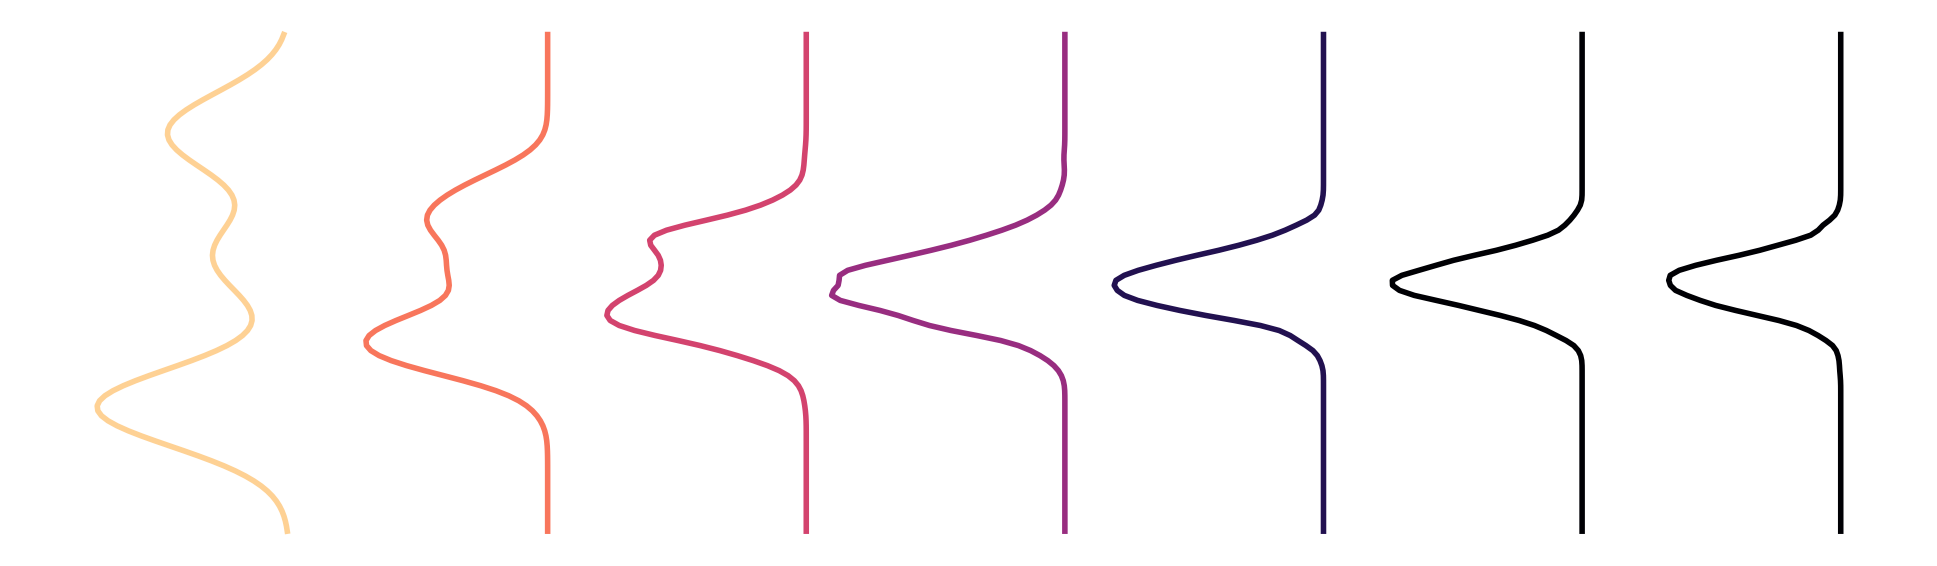

In [161]:
import numpy as np
from scipy.stats import gaussian_kde

magma = plt.get_cmap("magma")
cNorm = colors.Normalize(vmin=1, vmax=int(num_diffusion_timesteps * 1.1))
diffusion_timesteps_colors_scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=magma)
diffusion_timesteps_colors_scalarMap.set_array([])


actual_distribution_mix = torch.distributions.Categorical(torch.tensor([0.5, 0.2, 0.3]))
actual_distribution_comp = torch.distributions.Normal(torch.tensor([-5, 1, 6]).float(), torch.tensor([1, 1, 1]).float())
actual_distribution = torch.distributions.MixtureSameFamily(actual_distribution_mix, actual_distribution_comp)

actual_samples = actual_distribution.sample([1024, 2])



fig, axes = plt.subplots(1, 1, figsize = (20, 6))



# 2. create a linspace to match the range over which the kde model is plotted
x = np.linspace(-10, 10, 100)

gkde = gaussian_kde(actual_samples.numpy()[...,0])
axes.plot(- gkde(x) * 1.2, x, color = diffusion_timesteps_colors_scalarMap.to_rgba(20), linewidth = 4, )


noised_trajectory = ddpm_model.noise(actual_samples.cuda())['x_t'].cpu()[...,0].numpy()

indices = [3, 6, 9, 15, 19]

x_offset = -0.2

x_flatten = 0.95


for ax_i, i in enumerate(indices, 1):
    #sns.kdeplot(noised_trajectory[:,i], bw_adjust=1.0, ax = axes[ax_i])
    gkde = gaussian_kde(noised_trajectory[:,i])
    offset = ax_i * x_offset
    height = gkde(x) * (x_flatten ** i)
    axes.plot(-(height + offset), x, linewidth = 4, color = diffusion_timesteps_colors_scalarMap.to_rgba(20 - (i + 1)))

ax_i += 1
i+= 1

final_samples = torch.randn(2048).numpy()
gkde = gaussian_kde(final_samples)
offset = ax_i * x_offset
height = gkde(x) * (x_flatten ** i)
axes.plot(-(height + offset), x, linewidth = 4, color = diffusion_timesteps_colors_scalarMap.to_rgba(20 - (i + 1)))

fig.tight_layout()
axes.spines[['right', 'top', 'left', 'bottom']].set_visible(False)
axes.set_xticks([])
axes.set_yticks([])


plt.savefig('z_mate50_symposium_images/diffusion_models_primer.svg', format = 'svg', transparent = True)